# Comparing the accuracy of the pade and hypergeometric integration methods in `wcosmo`

`wcosmo` supports two integration methods for evaluating integrals like $\int \frac{dz (1 + z)^{\lambda}}{E(z)}$.

- a Pade approximation method, which is the default
- a hypergeometric method, which can be selected by setting `method='analytic'`

In this notebook, we compare the accuracy with respect to `astropy`.

The `analytic` and `astropy` method agree to machine precision and the `pade` method is slightly less precise.
Note that only the `pade` method support GPU/TPU acceleration.

In [1]:
import wcosmo
import numpy as np
import matplotlib.pyplot as plt
from astropy.cosmology import FlatwCDM
from astropy.constants import c

In [2]:
# define some constants we will use throughout
Clight = c.value
z_arr = np.linspace(0.0001, 5, num=100)
H0_vals = [50, 70, 90]
Om_vals = [0.1, 0.3, 0.5, 0.9]
colors = ["blue", "orange", "purple", "green"]
w_vals = [-2, -3 / 2, -1, -1 / 2, -1 / 3, 0]

## Comparisons between `astropy.cosmology` and `wcosmo`
Let's start by determining how accurate `wcosmo` is for $H_0\in [30,90] \text{km/s/kpc}$, $\Omega_m \in [0.1,0.9]$, and $w\in[-2,0]$.

We define two plotting functions that we will use for this whole section.

In [4]:
def cosmo_generator(H0, Om0, w, idx):
    if idx == 0:
        return FlatwCDM(H0=H0, Om0=Om0, w0=w)
    elif idx == 1:
        return wcosmo.FlatwCDM(H0=H0, Om0=Om0, w0=w)
    elif idx == 2:
        return wcosmo.FlatwCDM(H0=H0, Om0=Om0, w0=w, method="analytic")
    else:
        raise ValueError(f"Unknown idx {idx}")


def absolute_comparison(
    func,
    H0_arr=H0_vals,
    Om_arr=Om_vals,
    w=-1,
    colors=colors,
    linestyles=["--", "solid", ":"],
    z_arr=z_arr,
):
    fig, axes = plt.subplots(
        nrows=1, ncols=2, sharex=True, sharey=True, figsize=(10, 5)
    )
    # axis 0: vary H0
    axes[0].set_title(f"Fix $\Omega_m=0.3$, $w={w:.2f}$, vary $H_0$")
    for H0, color in zip(H0_arr, colors):
        for line, idx in zip(linestyles, range(3)):
            axes[0].plot(
                z_arr,
                cosmo_generator(H0, 0.3, w, idx).__getattribute__(func)(z_arr),
                ls=line,
                lw=3,
                c=color,
                label=f"$H_0=${H0} km/s/kpc" if idx == 0 else None,
            )
    axes[0].set_ylabel(" ".join(func.title().split("_")))

    # axis 1: vary Om0
    axes[1].set_title(f"Fix $H_0=70$, $w={w:.2f}$, vary $\Omega_m$")
    for Om, color in zip(Om_arr, colors):
        for line, idx in zip(linestyles, range(3)):
            axes[1].plot(
                z_arr,
                cosmo_generator(70, Om, w, idx).__getattribute__(func)(z_arr),
                ls=line,
                lw=3,
                c=color,
                label=f"$\Omega_m=${Om}" if idx == 0 else None,
            )

    for i in [0, 1]:
        axes[i].plot([], c="k", ls=linestyles[1], label="astropy")
        axes[i].plot([], c="k", ls=linestyles[0], lw=3, label="wcosmo - pade")
        axes[i].plot([], c="k", ls=linestyles[2], lw=3, label="wcosmo - hypergeometric")
        axes[i].legend(ncol=2)
        axes[i].set_xlabel("z")
        axes[i].set_ylim(bottom=0)
        axes[i].set_xlim(left=0)
    return fig


def fractional_comparison(
    func,
    H0_arr=H0_vals,
    Om_arr=Om_vals,
    w=-1,
    colors=colors,
    z_arr=z_arr,
    logscaley=True,
    linestyles=["--", "solid", ":"],
):
    fig, axes = plt.subplots(
        nrows=1, ncols=2, sharex=True, sharey=False, figsize=(10, 5)
    )
    # axis 0: vary H0
    axes[0].set_title(f"Fix $\Omega_m=0.3$, $w={w:.2f}$, vary $H_0$")
    for H0, color in zip(H0_arr, colors):
        ap = cosmo_generator(H0, 0.3, w, 0).__getattribute__(func)(z_arr).value
        wcos1 = cosmo_generator(H0, 0.3, w, 1).__getattribute__(func)(z_arr).value
        wcos2 = cosmo_generator(H0, 0.3, w, 2).__getattribute__(func)(z_arr).value
        fracerr_ap_wcosmo = np.abs(wcos1 - ap) / ap
        fracerr_ap_ak = np.abs(wcos2 - ap) / ap
        fracerr_ak_wcosmo = np.abs(wcos1 - wcos2) / wcos2

        axes[0].plot(
            z_arr,
            fracerr_ap_wcosmo,
            ls=linestyles[0],
            c=color,
            alpha=0.5,
            label=f"$H_0=${H0} km/s/kpc",
        )
        axes[0].plot(z_arr, fracerr_ap_ak, ls=linestyles[1], c=color, alpha=0.5)
        axes[0].plot(z_arr, fracerr_ak_wcosmo, ls=linestyles[2], c=color, alpha=0.5)
    title = " ".join(func.split("_"))
    axes[0].set_ylabel(
        "$\\frac{\\Delta \\text{%s}}{\\text{astropy %s}}$" % (title, title)
    )

    # axis 1: vary Om0
    axes[1].set_title(f"Fix $H_0=70$, $w={w:.2f}$, vary $\Omega_m$")
    for Om, color in zip(Om_arr, colors):
        ap = cosmo_generator(70, Om, w, idx=0).__getattribute__(func)(z_arr).value
        wcos1 = cosmo_generator(70, Om, w, idx=1).__getattribute__(func)(z_arr).value
        wcos2 = cosmo_generator(70, Om, w, idx=2).__getattribute__(func)(z_arr).value
        fracerr_ap_wcosmo = np.abs(wcos1 - ap) / ap
        fracerr_ap_ak = np.abs(wcos2 - ap) / ap
        fracerr_ak_wcosmo = np.abs(wcos1 - wcos2) / wcos2

        axes[1].plot(
            z_arr,
            fracerr_ap_wcosmo,
            ls=linestyles[0],
            c=color,
            alpha=0.5,
            label=f"$\Omega_m=${Om}",
        )
        axes[1].plot(z_arr, fracerr_ap_ak, ls=linestyles[1], c=color, alpha=0.5)
        axes[1].plot(z_arr, fracerr_ak_wcosmo, ls=linestyles[2], c=color, alpha=0.5)
    for i in [0, 1]:
        axes[i].legend()
        axes[i].set_xlabel("z")
        axes[i].set_xlim(left=0)
        if logscaley:
            axes[i].set_yscale("log")
        else:
            axes[i].set_ylim(bottom=0)
    return fig

### $w=-1$
#### luminosity distance

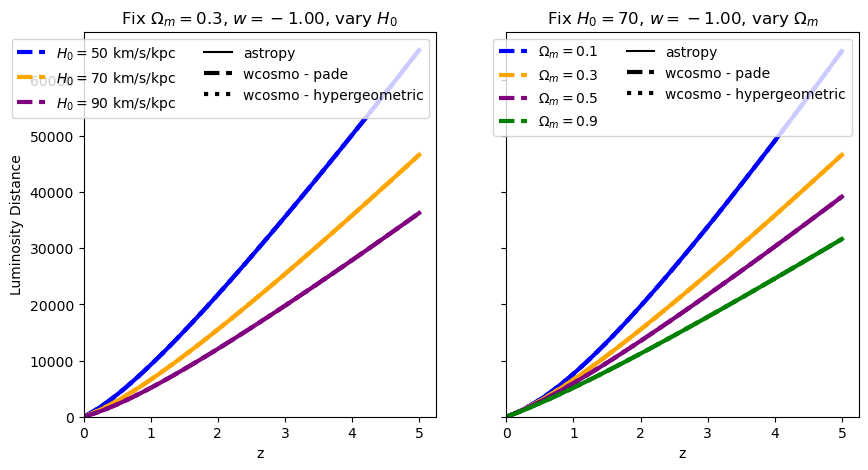

In [5]:
absolute_comparison("luminosity_distance");

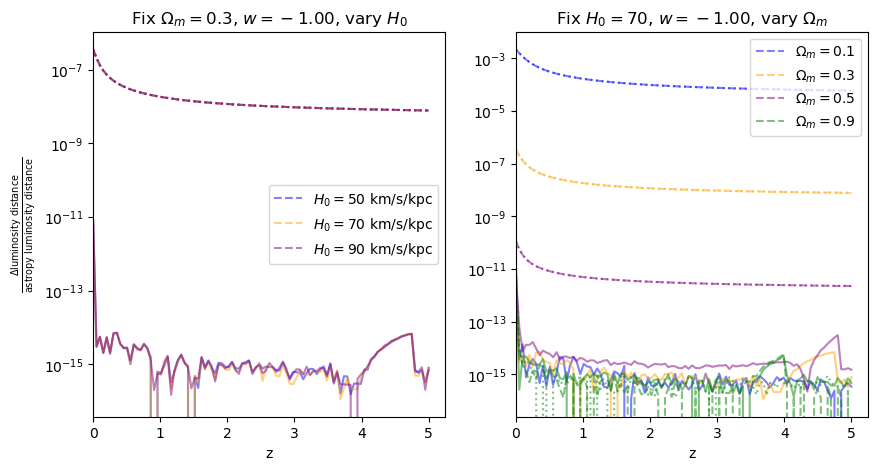

In [6]:
fractional_comparison("luminosity_distance");

When $\Omega_m=0.9$, the fractional error is comparable to floating point precision, which is why it looks a bit jaggedy.

#### $\frac{dV_c}{dz}$: differential comoving volume

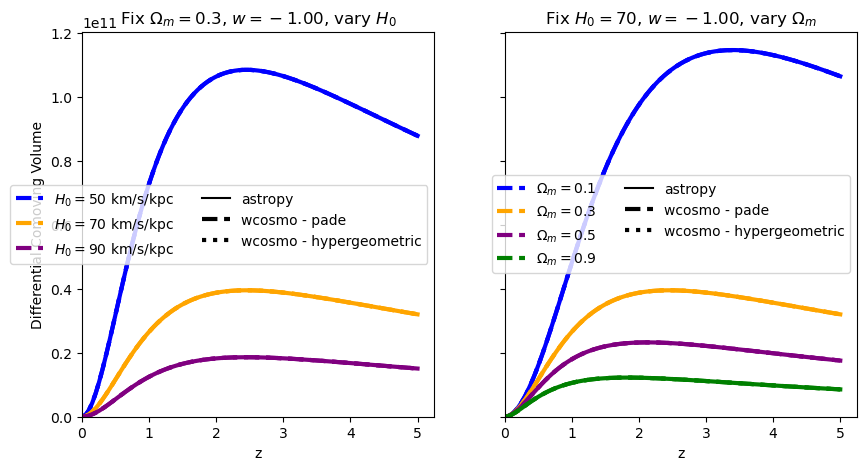

In [7]:
absolute_comparison("differential_comoving_volume");

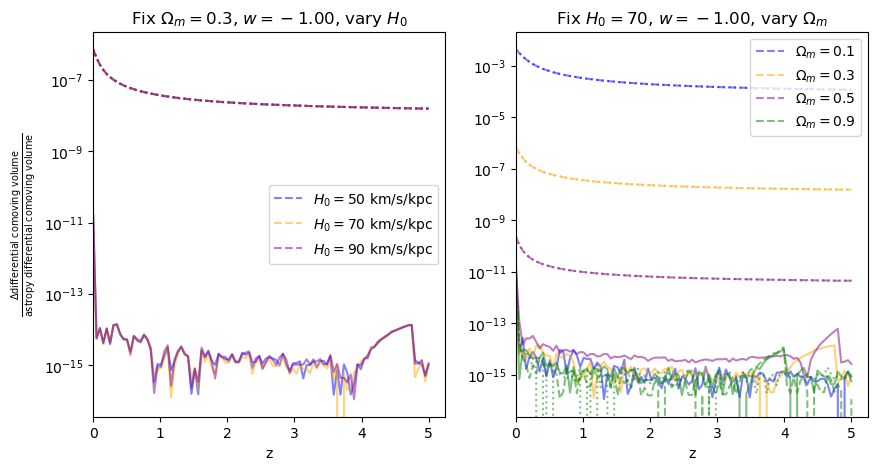

In [8]:
fractional_comparison("differential_comoving_volume");

#### $\frac{d D_L}{dz}$: Jacobian between luminosity distance and redshift
Used commonly in GW data analysis

Text(0, 0.5, '$\\frac{dD_L}{dz} [Mpc]$')

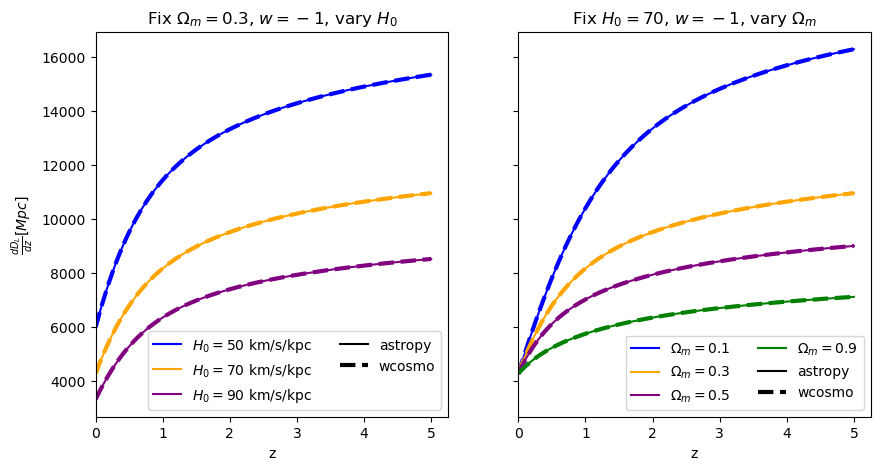

In [9]:
def dDL_dz(astropycosmo, z):
    dL = astropycosmo.luminosity_distance(z).value
    Ez_i = astropycosmo.inv_efunc(z)
    D_H = (Clight / 1e3) / astropycosmo.H0.value
    return np.abs(dL / (1.0 + z) + (1.0 + z) * D_H * Ez_i)


fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(10, 5))
# axis 0: vary H0
axes[0].set_title("Fix $\Omega_m=0.3$, $w=-1$, vary $H_0$")
for H0, color in zip(H0_vals, colors):
    axes[0].plot(
        z_arr, wcosmo.FlatLambdaCDM(H0=H0, Om0=0.3).dDLdz(z_arr), ls="--", lw=3, c=color
    )
    axes[0].plot(
        z_arr,
        dDL_dz(FlatwCDM(H0=H0, Om0=0.3), z_arr),
        c=color,
        label=f"$H_0=${H0} km/s/kpc",
    )
axes[0].plot([], c="k", label="astropy")
axes[0].plot([], c="k", ls="--", lw=3, label="wcosmo")
axes[0].legend(ncol=2)

# axis 1: vary Om0
axes[1].set_title("Fix $H_0=70$, $w=-1$, vary $\Omega_m$")
for Om, color in zip(Om_vals, colors):
    axes[1].plot(
        z_arr, wcosmo.FlatLambdaCDM(H0=70, Om0=Om).dDLdz(z_arr), ls="--", lw=3, c=color
    )
    axes[1].plot(
        z_arr, dDL_dz(FlatwCDM(H0=70, Om0=Om), z_arr), c=color, label=f"$\Omega_m=${Om}"
    )
axes[1].plot([], c="k", label="astropy")
axes[1].plot([], c="k", ls="--", lw=3, label="wcosmo")
axes[1].legend(ncol=2)

for i in [0, 1]:
    axes[i].set_xlabel("z")
    axes[i].set_xlim(left=0)
axes[0].set_ylabel("$\\frac{dD_L}{dz} [Mpc]$")

We find that the relative error is just a function of $\Omega_m$ and redshift, not $H_0$, which is expected as the approximant only changes $D_L(z)$, leaving $H_0$ as a constant factor common to both `wcosmo` and `astropy`'s calculations. 

### $w\neq-1$

This is where `wcosmo` differs from A&K2011. Let's compare what we get with `astropy`, for various values of $w$.

#### Luminosity distance

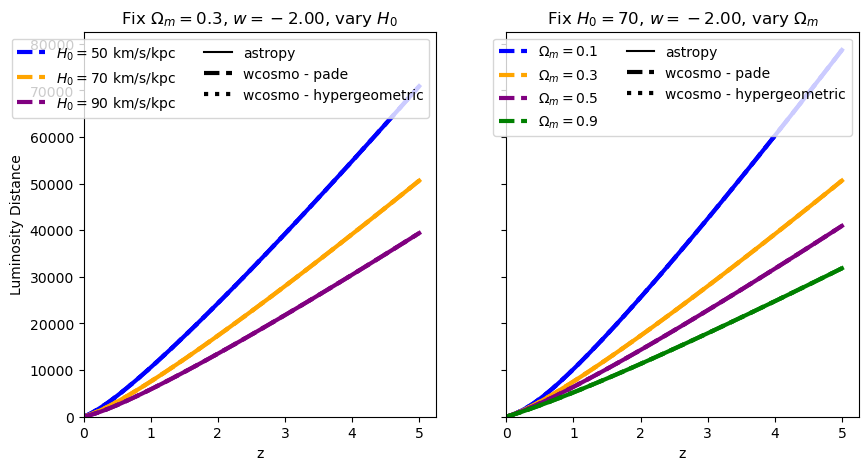

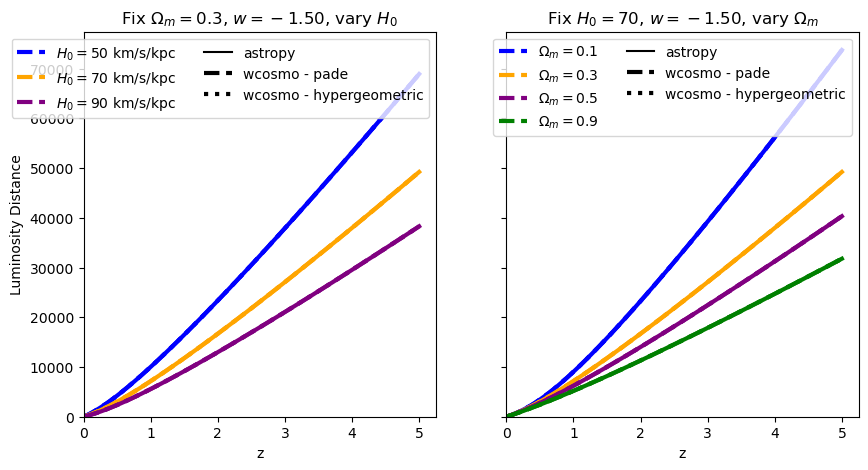

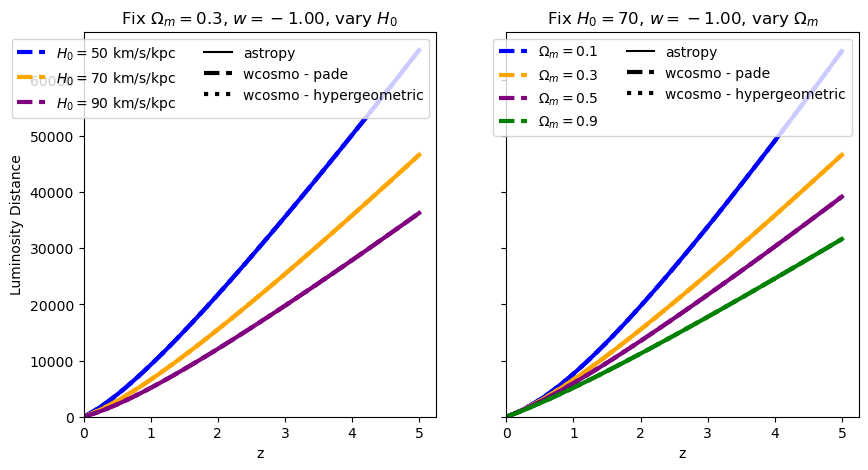

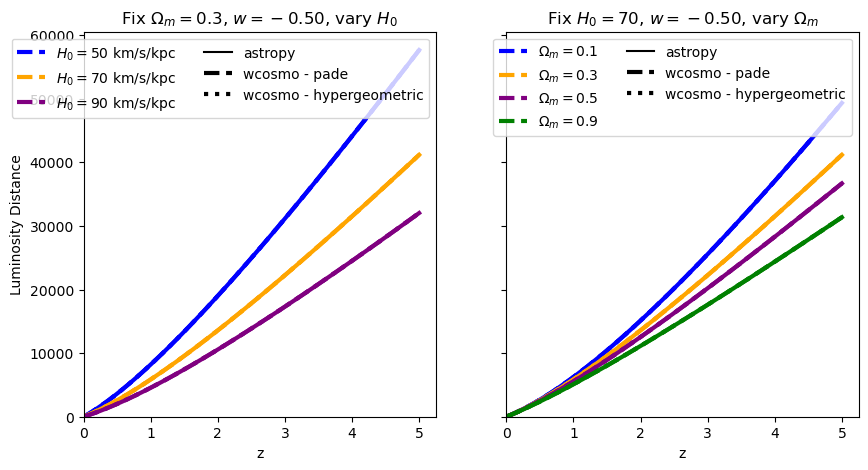

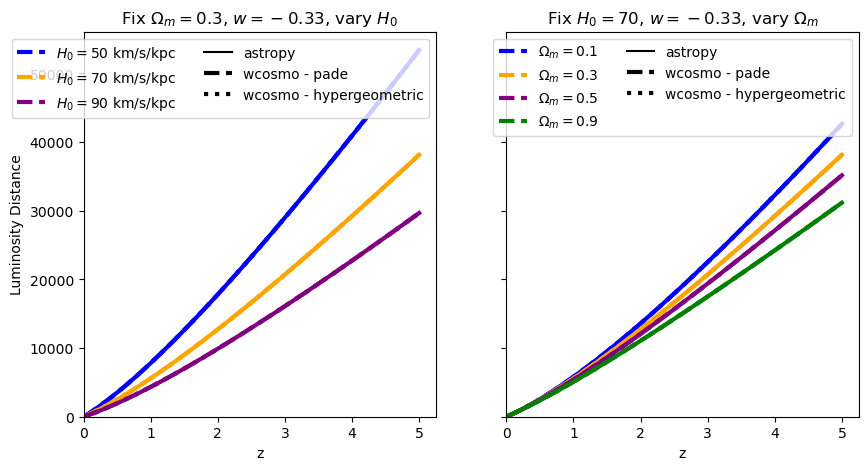

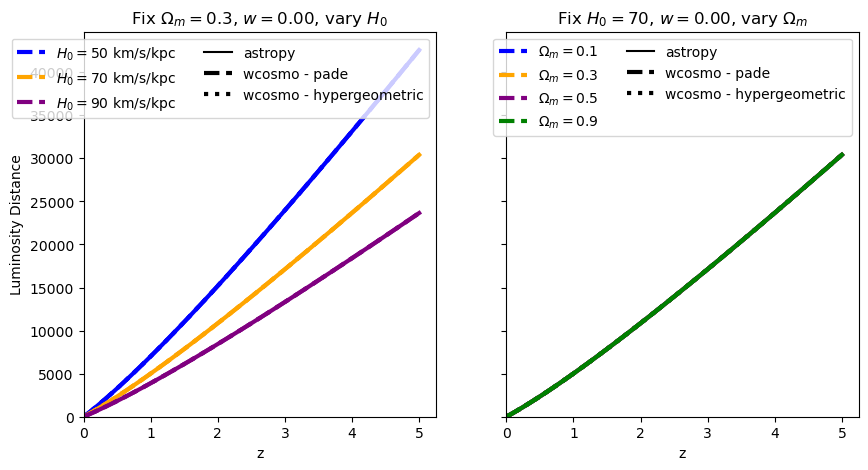

In [10]:
for w in w_vals:
    absolute_comparison("luminosity_distance", w=w)

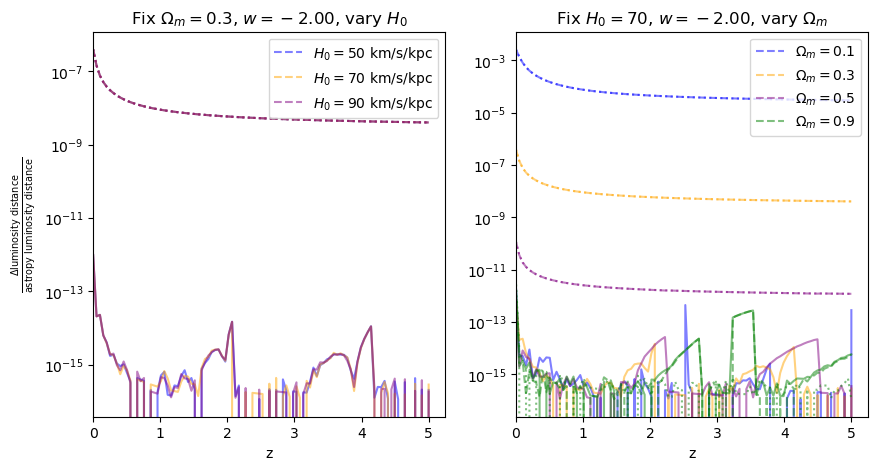

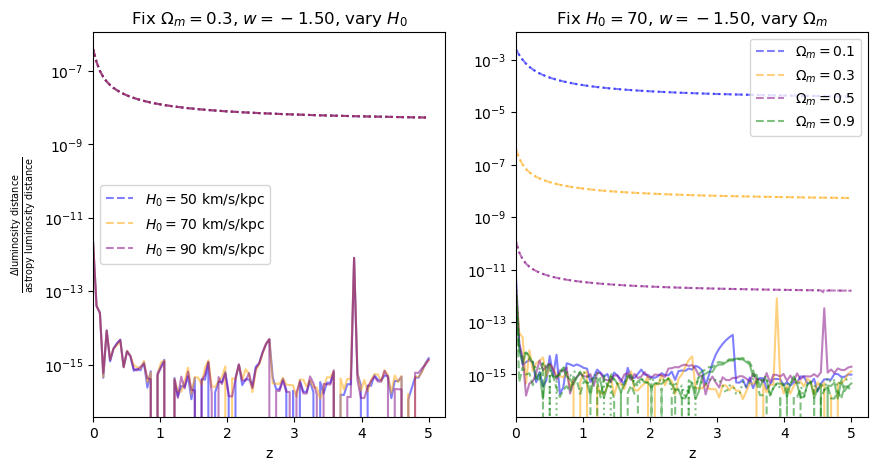

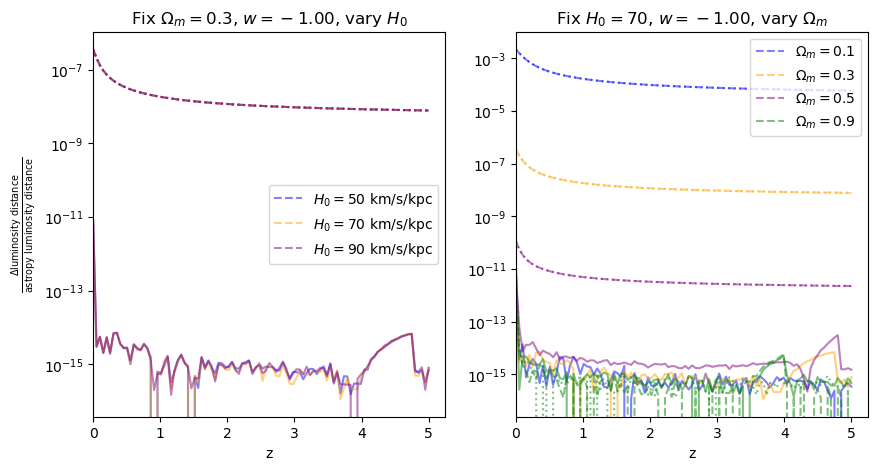

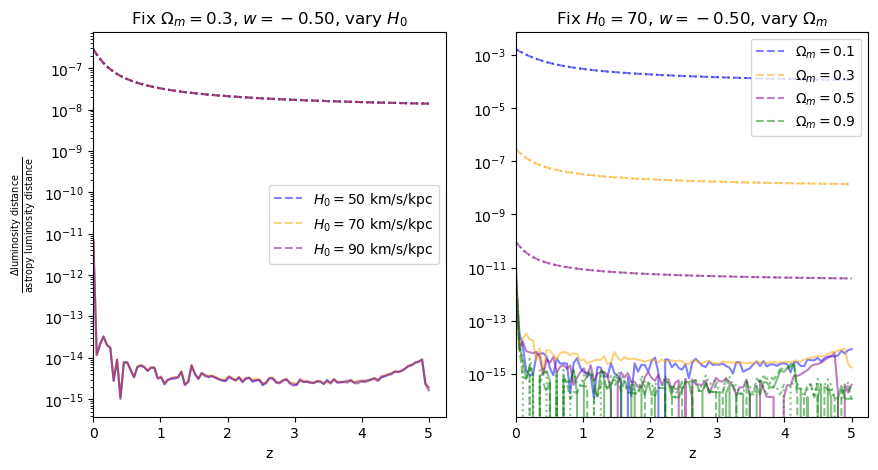

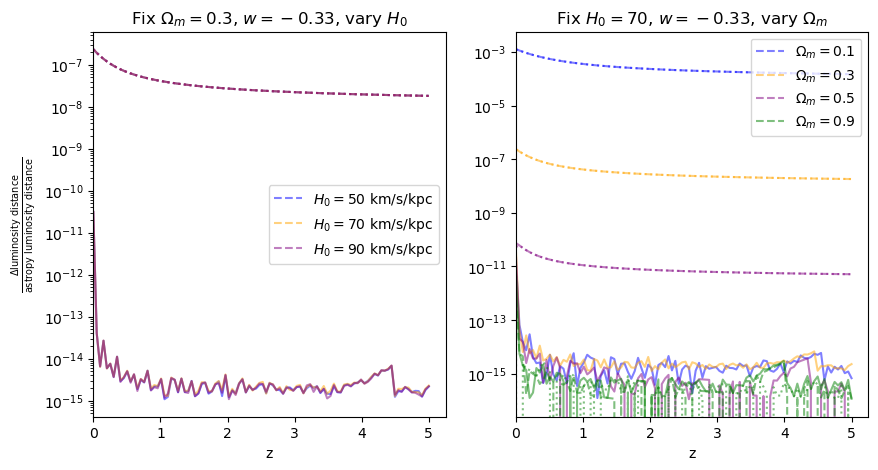

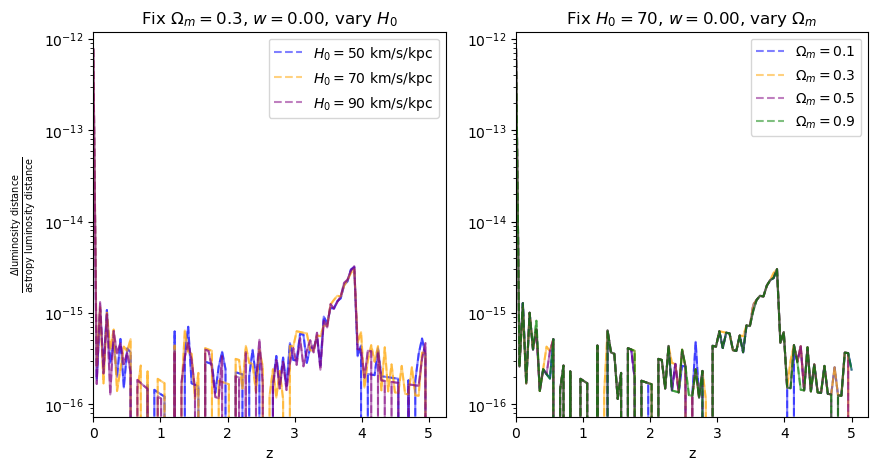

In [11]:
for w in w_vals:
    fractional_comparison("luminosity_distance", w=w)

### $\frac{dV_c}{dz}$: differential comoving volume

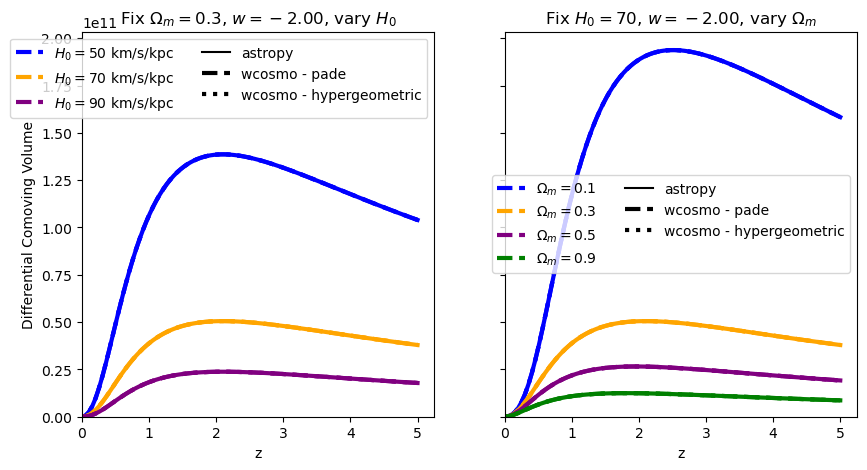

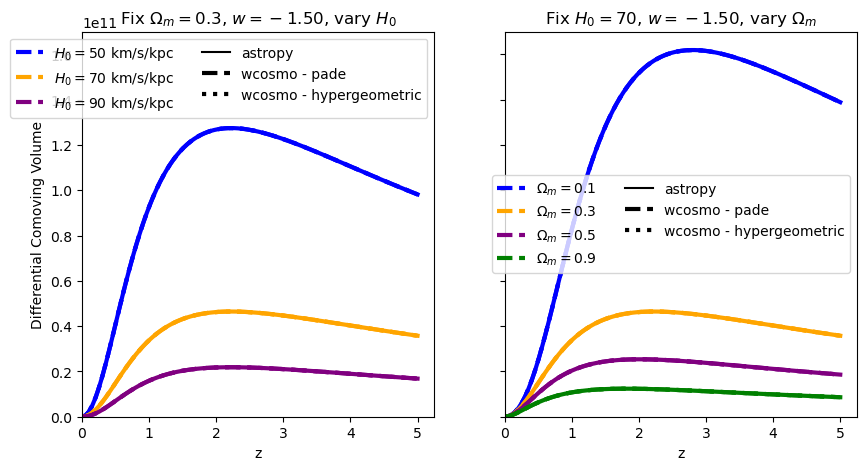

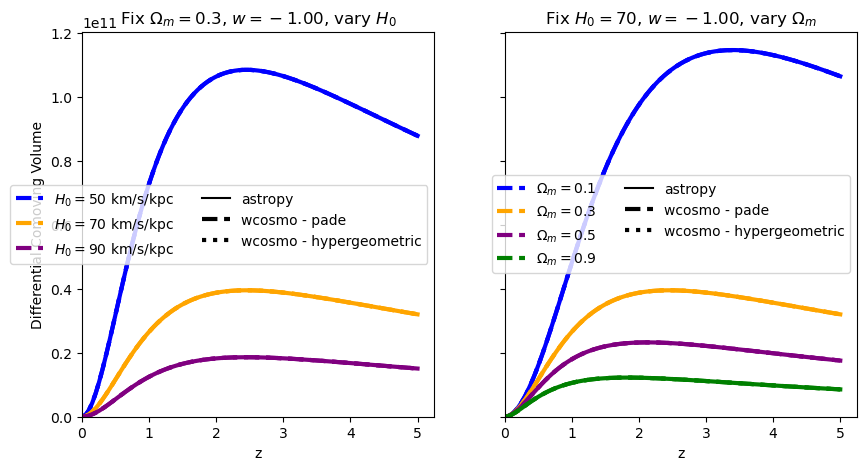

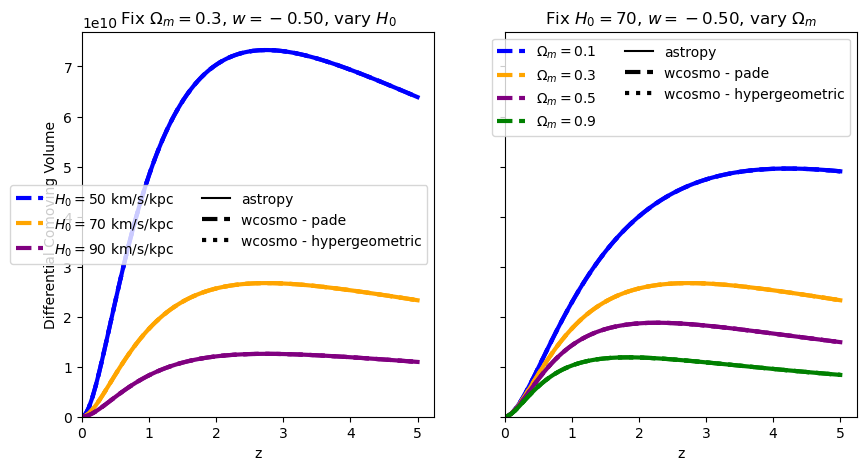

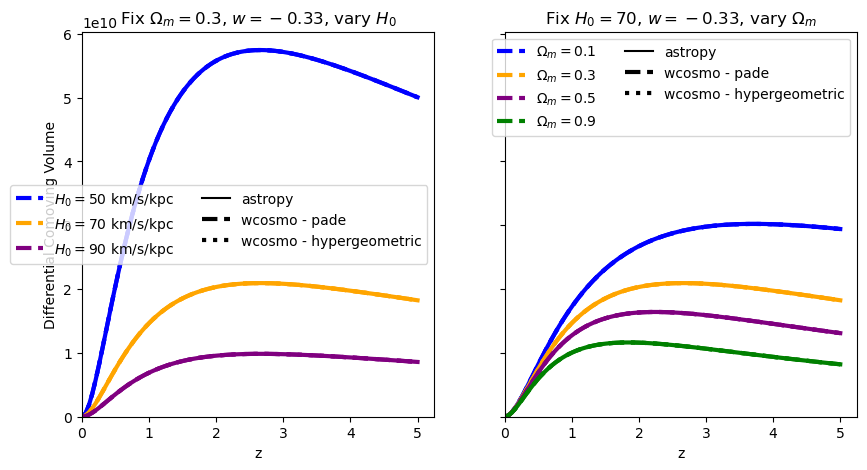

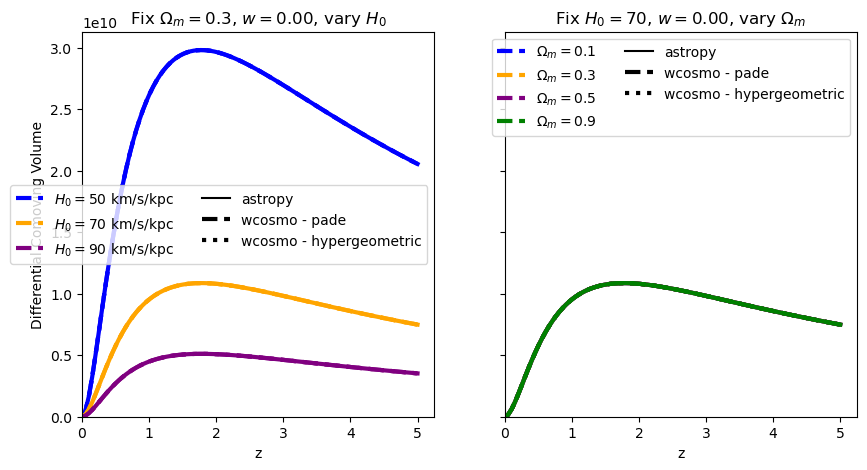

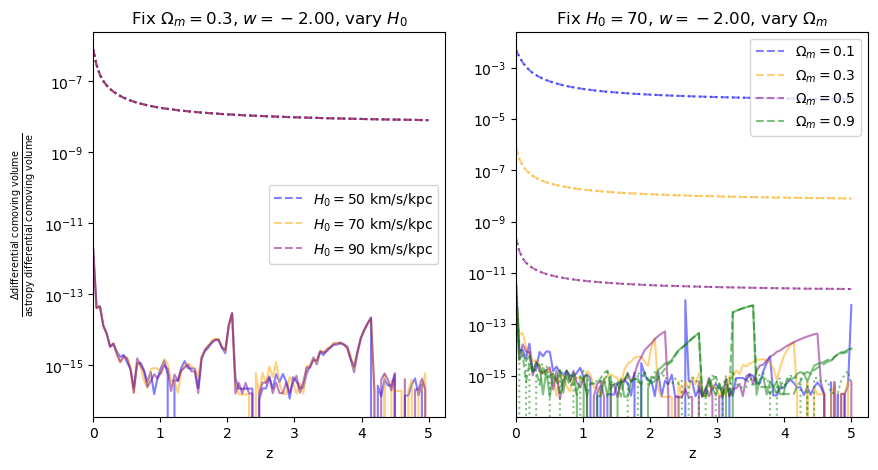

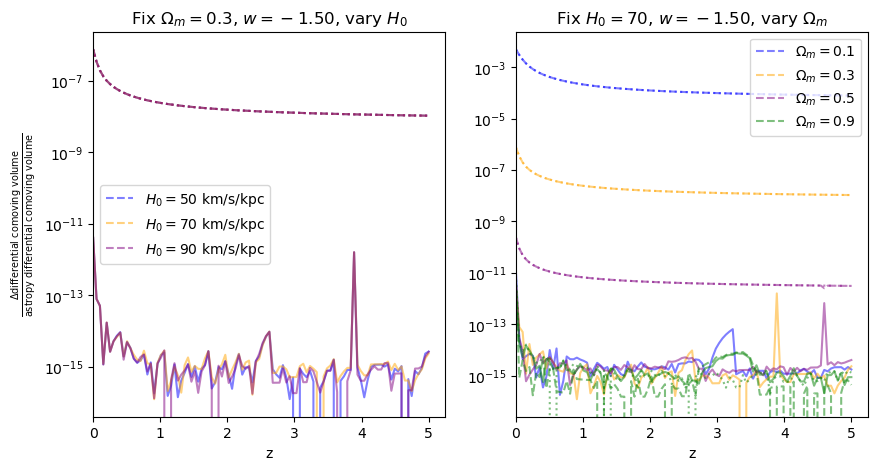

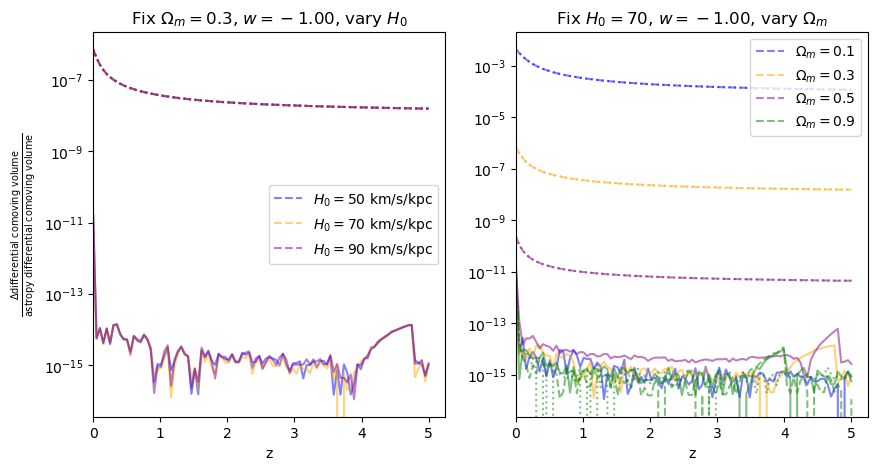

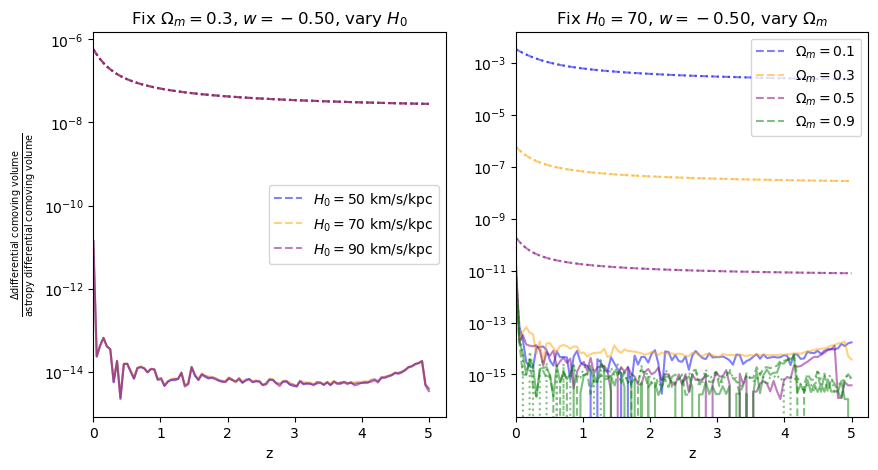

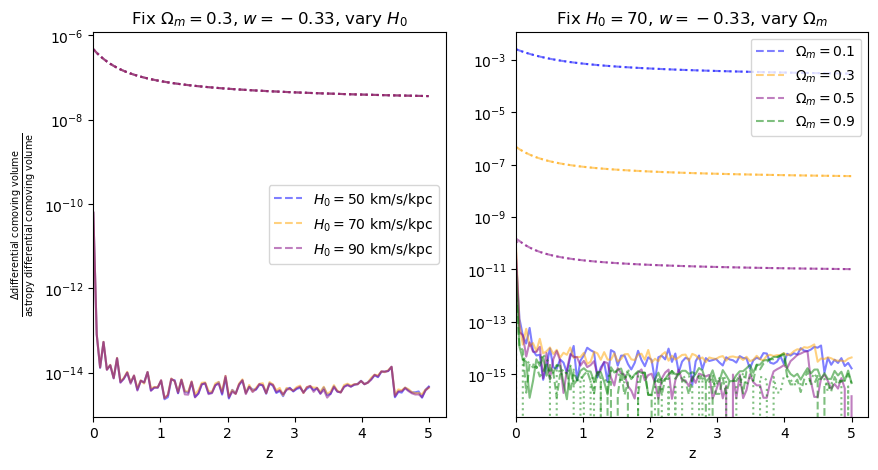

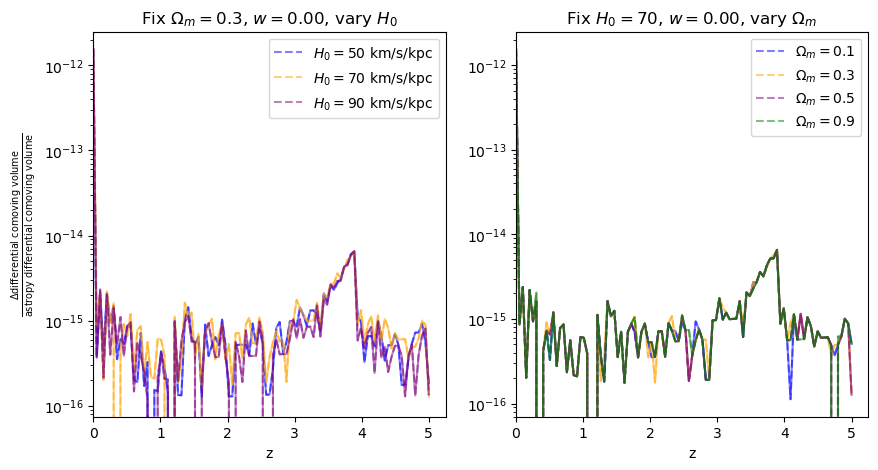

In [12]:
for w in w_vals:
    f = absolute_comparison("differential_comoving_volume", w=w)
for w in w_vals:
    f = fractional_comparison("differential_comoving_volume", w=w)